# An LSTM approach to Predict Migration based on Google Trends #

Code by : Nicolas Golenvaux and Pablo Gonzalez Alvarez

This notebook contains the companion code for the paper 
[An LSTM approach to Predict Migration based on Google Trends](https://) by Nicolas Golenvaux, Pablo Gonzalez Alvarez, Harold Silvère Kiossou, Pierre Schaus  


## Research question ##

In this work we use the exact same data, but we replace the linear model by a recurrent neural network (LSTM [2, 3]) that is able to consider the whole history to make predictions.

We demonstrate that the prediction quality can be drastically improved by capturing better complex migration dynamics [4] and complex interactions between the many features.




Please run the following cell to load all the packages required for this notebook. If ran locally, be sure to have all the necessary packages installed beforehand.

In [0]:
import keras.backend as kb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data set ##
As a starter, we first preprocess the data from [1]. We have basically two types of sequential data spanning from 2004 to 2014 : 
* Economic and demographic data, e.g., GDP, population size, migration numbers;
* Google Trends Index, as defined in [1].

### Pre-processing ###

The preprocessing is done in two steps : 

* We first convert stata bilateral data from [1] into a simpler dataframe
* We normalize for the LSTM 


In [0]:
# Transforms the stata file into a dataframe that can be manipulated more easily  
#
# @data                 : dataframe from [1] stata file (.dta extension)
# @returns              : a dframe, each row is a time series for a pair id destination-origin, e.g AUS-AUT where the columns are :
#       - 'origin'          : code iso3 for the origin country 
#       - 'dest'            : code iso3 for the origin country
#       - 'year'            : the list of years for which we have migration data flow between the 2 countries
#       - 'language'        : the part of the population of the origin country speaking French/Spanish/English
#       - 'control_var'     : for each year it contains the different control variables on the countries of origin and destination (population, GDP, ...)
#       - 'GTI'             : for each year it contains the non-normalized GTI values (uni and bi) for the different keywords
#       - 'fixed_effects'   : the one-hot vectors representing the country of origin, of destination and the year of the data
#       - 'y'               : the output value the LSTM will try to predict
#       - 'tot_mig'         : the non-normalized migration flow between the 2 countries for each year
#       - 'internet'        : the part of the population of the origin country having acess to internet 
# @use_log              : use the log value? Instead of the total value for the output and for the control variables
# @fixed_effects_origin : use origin fixed effects?
# @fixed_effects_dest   : use destination fixed effects?
# @fixed_effects_year   : use year fixed effects? (use maybe year since GT discontinuity from January 2011 ?)
# @normInTotal          : indicates if the data should be normalized over every time-series
def getDataLSTM(oldData, fixed_effects_origin = True, fixed_effects_dest = True, fixed_effects_year = True, use_log = False, normInTotal = False):
    data = oldData.copy()
    list_origins = list(dict.fromkeys(data['iso3_o']))
    list_dests = list(dict.fromkeys(data['iso3_d']))
    list_years = list(dict.fromkeys(data['year']))
    def addFixed_effects(row):
        Xfixed_effects = []
        if fixed_effects_origin:
            fx_o = [0.] * len(list_origins)
            fx_o[list_origins.index(row['iso3_o'])] = 1.
            Xfixed_effects += fx_o
        if fixed_effects_dest:
            fx_d = [0.] * len(list_dests)
            fx_d[list_dests.index(row['iso3_d'])] = 1.
            Xfixed_effects += fx_d
        if fixed_effects_year:
            fx_y = [0.] * len(list_years)
            fx_y[list_years.index(row['year'])] = 1.
            Xfixed_effects += fx_y
        return Xfixed_effects
    uniGTI_col = data.columns[13:80] # e.g. "visa"
    biGTI_col = data.columns[81:148] # e.g. "visa Australia"
    control_var_col = data.columns[161:165]
    if use_log: # logarithm base e
      control_var_col = data.columns[9:14]
    uniGTI = np.array(data[uniGTI_col]) * np.array(data['GTI_bil_0']).reshape((data.count()[0],1))
    biGTI = np.array(data[biGTI_col])
    control_var = np.array(data[control_var_col])
    language = data[['o_French','o_Spanish','o_English']].apply(max,axis=1)
    fixed_effects = list(data.apply(addFixed_effects, axis=1))
    GTI = np.hstack((biGTI,uniGTI))
    y = np.array(data['fwd_tot_mig']).reshape((len(data['fwd_tot_mig']),1))
    data['fwd_tot_mig'] = y.tolist()
    if normInTotal:
      y = MinMaxScaler(feature_range=(0, 1)).fit_transform(y)
      control_var = MinMaxScaler(feature_range=(0, 1)).fit_transform(control_var)
    if use_log:
      y = np.array(data['fwd_log_mig']).reshape((len(data['fwd_log_mig']),1))
    data['GTI'] = GTI.tolist()
    data['fixed_effects'] = fixed_effects
    data['control_var'] = control_var.tolist()
    data['y'] = y.tolist()
    data['language'] = language
    groupedData = data.groupby(['pair_id']).agg({'iso3_o':lambda x:x.tolist()[0], 'iso3_d':lambda x:x.tolist()[0], 'year':lambda x:x.tolist(), 'control_var':lambda x:x.tolist(), 'GTI':lambda x:x.tolist(), 'fixed_effects':lambda x:x.tolist(), 'y':lambda x:x.tolist(), 'fwd_tot_mig':lambda x:x.tolist(), 'language':lambda x:x.tolist()[0], 'o_IT_NET_USER_P2':lambda x:np.mean(x.tolist())})
    groupedData.rename(columns={'iso3_o':'origin','iso3_d':'dest','fwd_tot_mig':'tot_mig','o_IT_NET_USER_P2':'internet'},inplace=True)
    return groupedData

In [0]:
# Transforms, normalizes and filters the data in order to be trained for a LSTM
#
# @dataLSTM     : dataFrame returned by the function getDataLSTM
# @normGTI      : should the GTI values be normalized by serie
# @normY        : should the input/output be normalized by serie
# @normControl  : should the control variables be normalized by serie
# @min_speak    : remove origin countries where the language is spoken by less than @least min_speak 
# @min_internet : remove origin countries where internet penetration is less than @least min_internet
# @min_length   : remove series origin-destination of length (=number of years) less than @min_length
# @returns      : another dataFrame, similar of the one passed in argument with one additionnal column :
#       - 'X'       : the (normalized) input data for the pair origin-destination, for each year it contains :
#       -             the (normalized) value of the migration flow between the 2 countries for the previous year
#       -             the (normalized) control variables of the countries of origin and destination
#       -             the (normalized) GTI values of the country of origin
#       -             the fixed_effects (one-hot vectors) representing the year, the origin and the destination
def transformData(dataLSTM, normGTI=True, normY=True,normControl= True, min_speak = 0.0, min_internet = 0.0, min_length = 0):
    newData = dataLSTM.copy()
    newData = newData.loc[newData['language'] >= min_speak]
    newData = newData.loc[newData['internet'] >= min_internet]
    newData = newData.loc[newData['y'].map(len) >= min_length]
    if normGTI:
        newData['GTI'] = newData['GTI'].apply(np.array).apply(MinMaxScaler(feature_range=(0, 1)).fit_transform)
    if normControl:
        newData['control_var'] = newData['control_var'].apply(np.array).apply(MinMaxScaler(feature_range=(0, 1)).fit_transform)
    if normY:
        newData['y'] = newData['y'].apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(list)
    pred_mig = newData['y'].apply(lambda l: [[0.0]] + l[:-1]).apply(np.array)
    newData['y'],newData['tot_mig'] = newData['y'].apply(np.array),newData['tot_mig'].apply(np.array)
    control_var,GTI,fixed_effects = newData['control_var'].apply(np.array),newData['GTI'].apply(np.array),newData['fixed_effects'].apply(np.array)
    X = [np.hstack((pred_mig[i],control_var[i],GTI[i],fixed_effects[i])) for i in pred_mig.index]
    newData['X'] = X
    return newData

### Import the dataset ###

In this section, the data is imported, preprocessed, and saved as a pickle file.

The research data from [3] can be downloaded on the following website : [https://www.sciencedirect.com/science/article/pii/S0304387819304900](https://www.sciencedirect.com/science/article/pii/S0304387819304900)

For convenience, the data is available in the `data` folder of this repository.


In [0]:
data = pd.read_stata('/data/replication_bilateral.dta')

## LSTM Model 

### Training, Validation and Testing ###

* The training set is the data from 2004--2012;
* The validation set is the data from 2013.


### Objective functions and metrics ###

#### Metrics ####

We use the following 4 metrics : 

* common part of commuters $cpc$ as defined in [5];
* root mean square error $rmse$;
* coefficient of determination $r^2$;
* mean absolute error $mae$.

Notice that both the $CPC$ and the $r^2$ are not defined in keras's backend and are thus defined here :




In [0]:
# Common Part of Commuters from [5]
def cpc(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))
# Coefficient of determination r^2
def r_squared(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - SS_res / (SS_tot + kb.epsilon())) 

custom_metrics = [cpc, 'mse', r_squared, 'mae'] # to be passed to model.compile(), metrics parameter

#### Loss functions ####


We use three loss functions on which we will train our model, one custom and two commonly used: 

* **Common Part of Commuters** _CPC_ as defined in [5]
* **Root Mean Square Error** _RMSE_
* **Mean Absolute Error** _MAE_

In [0]:
# Common Part of Commuters loss from [5]
def cpc_loss(y_true, y_pred):
    return 1.0 - cpc(y_true, y_pred)

loss = [cpc_loss, 'mse', 'mae'] # to be passed to model.compile(), loss parameter

### Building the model and training ###

In [0]:
# Train the model on the data passed in argument 
# 
# @model     : lstm (keras model)
# @data      : a dataframe like the transformData return
# @verbose   : should I show epoch (0 shut up) 
# @epoch     : number of epoch
# @test_year : the year used as test set
def train(model, data, verbose = 0, epoch = 1,test_year = 2014):
    def trainModel(row):
        X, y = row['X'], row['y'] # I take a series that is a pair origin-dest spanning from 2004-2014 (some missing years maybe)
        if test_year in row['year']: # Remove the test year from the train
            X, y = row['X'][:-1], row['y'][:-1]
        if len(X) != 0:
            X = np.array(X).reshape((len(X),1,len(X[0]))) # batch size, years I take, number of feats
            model.fit(X, y, epochs = epoch, verbose = verbose, shuffle = False) # loss, metrics pour le train 
    for j in range(epoch): # repeat the traning on the whole data epoch times
        data.apply(trainModel, axis = 1)
        print('end of epoch :', j + 1)

In [0]:
# Train the model on the data passed in argument and evaluate it every @evaluate_freq epochs
#
# @model         : lstm (keras model)
# @data          : a dataframe like the transformData return
# @verbose       : should I show epoch (0 shut up) 
# @epoch         : number of epoch
# @test_year     : the year used as test set
# @normBySerie   : indicates for the evaluation if @data was normed by serie origin-destination
# @use_log       : indicates for the evaluation if the log values was used in @data
# @normInTotal   : indicates for the evaluation if @data was normed for all series origin-destination
# @evaluate_freq : the model is evaluated every @evaluate_freq epochs
# @returns       : the history of the different metrics for every evaluation done
def train_evaluate(model, data, verbose = 1, epoch = 1, test_year = 2014, normBySerie = True, use_log = False, normInTotal = False, evaluate_freq = 5):
    def trainModel(row):
        X, y = row['X'], row['y'] # I take a series that is a pair origin-destination spanning from 2004-2014 (some missing years maybe)
        if test_year in row['year']: # Remove the test year from the train
            X, y = row['X'][:-1], row['y'][:-1]
        if len(X) != 0:
            X = np.array(X).reshape((len(X),1,len(X[0]))) # batch size, years I take, # of feats
            model.fit(X, y, epochs = 1, verbose = 0, shuffle = False) # loss, metrics for the train
    history = [] # for train and test metrics at every epoch
    for j in range(epoch): # repeat the traning on the whole data epoch times
        data.apply(trainModel,a xis=1)
        if j%evaluate_freq == 0: #evaluation on all the different metrics
          dataResult = evaluateBySerie(model, data, normBySerie = normBySerie, use_log = use_log, normInTotal = normInTotal)
          train_metrics, test_metrics, total_train_metrics, total_test_metrics = totalEvaluation(dataResult, display = False, test_year = test_year)
          train_mae_by_dest, test_mae_by_dest = evaluation_year_dest(dataResult, 'y_diff', display = False, test_year = test_year)
          history.append(total_train_metrics + [train_mae_by_dest] + total_test_metrics + [test_mae_by_dest])
          print('EPOCH :', j + 1)
          if verbose > 0:
              print('train rmse : ' + str(total_train_metrics[0]) + ' - train mae : ' + str(total_train_metrics[1]) + ' - train r2 : ' + str(total_train_metrics[2]) + ' - train cpc : ' + str(total_train_metrics[3]) + ' - train mae by dest : ' + str(train_mae_by_dest))
              print('test rmse : ' + str(total_test_metrics[0]) + ' - test mae : ' + str(total_test_metrics[1]) + ' - test r2 : ' + str(total_test_metrics[2]) + ' - test cpc : ' + str(total_test_metrics[3]) + ' - test mae by dest : ' + str(test_mae_by_dest))
              print()
    return list(map(list,zip(*history)))


In [0]:
# Display the training history of the model, the values of the different metrics
# as returned by train_evaluate
#
# @history : of the different metrics by epoch for a given model
def display_training(history):
  model_metrics = history
  half = int(len(model_metrics) / 2)
  name_metrics = ['rmse', 'mae', 'r2', 'cpc', 'mae on total incoming migrants']
  train_metrics, val_metrics = model_metrics[:half], model_metrics[half:]
  ratio = 10 # for figure size
  fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
  fig.tight_layout(pad=3.0)
  for i in range(half):
      ax[i].set_title(name_metrics[i] + ' on train and validation sets')
      ax[i].plot(train_metrics[i])
      ax[i].plot(val_metrics[i])
      ax[i].set_ylabel(name_metrics[i])
      ax[i].set_xlabel('Number of epochs')
      ax[i].legend(['Train', 'Validation'], loc='upper right')

In [0]:
# Define the lstm model
#
# @data              : a dataframe like the transformData return
# @l                 : loss function to build model
# @size_hidden_layer : size of the LSTM's hidden layer
# @dropout           : value of the model's dropout
# @returns           : the defined model
def defineModel(data, l = cpc_loss, size_hidden_layer = 50, dropout = 0.0):
  n_features = len(data['X'][171][0]) 
  model = Sequential()
  if dropout > 0.0:
    model.add(Dropout(dropout, input_shape=(1, n_features)))
  model.add(LSTM(size_hidden_layer, activation='relu', input_shape=(1, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss=l, metrics = custom_metrics)
  return model

### Validation and testing methods###


In [0]:
# Calculate the CPC metrics for the predicted output y_pred with the real output y
# This is the same definition given above for the cpc metric, but using numpy instead of the keras backend
# @y and y_pred are 2 numpy.arrays of the same length
def CPC(y,y_pred):
    return 2 * np.sum(np.minimum(y,y_pred))/(np.sum(y)+np.sum(y_pred))

# Calculate the metrics rmse, mae, r2 and cpc for the predicted output y_pred with the real output y
#
# @y and y_pred are 2 numpy.arrays of the same length
def calculate_metrics(y,y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y,y_pred))
    mae = metrics.mean_absolute_error(y,y_pred)
    r2 = metrics.r2_score(y,y_pred)
    Cpc = CPC(y,y_pred)
    return [rmse,mae,r2,Cpc]

# Evaluate the LSTM model by calculating for each series the metrics rmse, mae, r2 and cpc on the normalized and denormalized output
#
# @model       : lstm (keras model)
# @newData     : dataFrame returned by the function transformData
# @normBySerie : indicates if the output data has been normalized by serie origin-destination
# @use_log     : indicates if the log of the output data has been used instead of the total value
# @normInTotal : indicates if the output data has been normalized for all origin-destination series 
# @returns     : another dataFrame, similar of the one passed in argument with 11 additionnal columns :
#       - 'y_pred'      : the output value predicted by the model
#       - 'y_real_pred' : the denormalized/total output value predicted by the model
#       - 'y_diff'      : the difference between the denormalized/total output value predicted by the model and the true denormalized/total output value
#       - 'rmse'        : the rmse value specific to the current serie (with the normalized output)
#       - 'mae'         : the mae value specific to the current serie (with the normalized output)
#       - 'r2'          : the r2 value (coefficient of correlation) specific to the current serie (with the normalized output)
#       - 'cpc'         : the cpc value specific to the current serie (with the normalized output)
#       - 'rmse_total'  : the rmse value specific to the current serie (with the denormalized/total output)
#       - 'mae_total'   : the mae value specific to the current serie (with the denormalized/total output)
#       - 'r2_total'    : the r2 value (coefficient of correlation) specific to the current serie (with denormalized/total output)
#       - 'cpc_total'   : the cpc value specific to the current serie (with the denormalized/total output)
def evaluateBySerie(model, newData, normBySerie = True, use_log = False, normInTotal = False):
    tot_mig = np.array([el for serie in list(newData['tot_mig']) for el in serie])
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(tot_mig)
    def evaluateRow(row):
        X, y, y_real = row['X'], row['y'], row['tot_mig']
        X = np.array(X).reshape((len(X), 1, len(X[0])))
        y_pred = model.predict(X,verbose=0)
        y_real_pred = y_pred
        if normBySerie:
          scalerSerie = MinMaxScaler(feature_range=(0, 1)).fit(y_real)
          y_real_pred = scalerSerie.inverse_transform(y_pred)
        elif use_log:
          y_real_pred = np.exp(y_pred)-1
        elif normInTotal:
          y_real_pred = scaler.inverse_transform(y_pred)
        y = y.flatten()
        y_pred = y_pred.flatten()
        y_real_pred = y_real_pred.flatten()
        y_diff = np.subtract(y_real_pred.flatten(), y_real.flatten())
        res = [y_pred,y_real_pred,y_diff] + calculate_metrics(y,y_pred) + calculate_metrics(y_real,y_real_pred)
        return res
    res = np.array(newData.apply(evaluateRow,axis=1).to_list())
    newDF =  pd.DataFrame(res, columns=['y_pred', 'y_real_pred', 'y_diff', 'rmse', 'mae', 'r2', 'cpc', 'rmse_total', 'mae_total','r2_total', 'cpc_total'], index=newData.index)
    return pd.concat([newData,newDF], axis=1)

# Evaluate the LSTM model by calculating for the complete data the metrics rmse, mae, r2 and cpc
# and display (or not) the difference between the predicetd values and the ground truth values and the scatter plot
#
# @data      : dataFrame returned by the function evaluateBySerie
# @test_year : the year used as test set
# @dislay    : should we display the graph of the difference of output and the scatter plot
# @returns   : 4 lists containing each the rmse, mae, r2 and cpc metrics for, respectively :
#       - train_metrics       : the normalized train set
#       - test_metrics        : the normalized test set
#       - total_train_metrics : the denormalized/total train set
#       - total_test_metrics  : the denormalized/total test set
def totalEvaluation(data,test_year = 2014,display=True):
    def separate(row):
        if test_year in row['year']:
            return [row['y'][:-1],[row['y'][-1]],row['y_pred'][:-1],[row['y_pred'][-1]],row['tot_mig'][:-1],[row['tot_mig'][-1]],row['y_real_pred'][:-1],[row['y_real_pred'][-1]]]
        else:
            return [row['y'],[],row['y_pred'],[],row['tot_mig'],[],row['y_real_pred'],[]]
    def flatten(l):
        return [[x for serie in set for x in serie] for set in l]
    allData = data.apply(separate,axis=1)
    allData = list(map(list,zip(*allData)))
    [y_train,y_test,y_train_pred,y_test_pred,y_real_train,y_real_test,y_real_train_pred,y_real_test_pred] = flatten(allData)
    if display :
        y_real = np.array(y_real_train + y_real_test)
        y_pred = np.array(y_real_train_pred + y_real_test_pred)
        y_diff_plot(y_real,y_pred,'y_diff_LSTM.svg')
        scatter_plot(np.array(y_real_test),np.array(y_real_test_pred),'scatter_LSTM.svg')
    y_real_train = np.array(y_real_train).reshape((len(y_real_train)))
    y_train = np.array(y_train).reshape((len(y_train)))
    y_real_test = np.array(y_real_test).reshape((len(y_real_test)))
    y_test = np.array(y_test).reshape((len(y_test)))
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    total_train_metrics = calculate_metrics(y_real_train, y_real_train_pred)
    total_test_metrics = calculate_metrics(y_real_test, y_real_test_pred)
    return train_metrics, test_metrics, total_train_metrics, total_test_metrics

In [0]:
# Calculate and display the sum of the @col values over all the origin countries for each destination country and each year
# 
# @data     : a Dataframe where each row is a serie origin-destination (like the ones returned by the functions transformData or evaluateBySerie)
# @col      : the name of the column of the @data dataFrame containing the values to sum
# @display  : indicates if it should display the heatmap of the values
# @test_year : the year corresponding to the test set
# @returns : the mean absolute values of @col for every destination country for the training and test set
def evaluation_year_dest(data, col, display=True,test_year=2014):
    years = list({y:None for row in list(data['year']) for y in row})
    dest = list(dict.fromkeys(data['dest']))
    groupedData = data.groupby(['dest']).agg({'year': lambda x:x.tolist(), col: lambda x:x.tolist()})
    # this function calculate the sum of the @col values over all the origin countries for every pair destination country-year
    def df(row):
        d = dict.fromkeys(years,0.0)
        for i in range(len(row['year'])):
            for j in range(len(row['year'][i])): 
                d[row['year'][i][j]] += float(row[col][i][j])
        return list(d.values())
    val = groupedData.apply(df,axis=1).to_list()
    df = pd.DataFrame(val,index = groupedData.index, columns = years) # creation of a new dataFrame where columns are years and rows countries
    mae_train = np.mean(np.abs(np.array(df.loc[:,df.columns != test_year]))) # mean absolute value for the training set
    mae_test = np.mean(np.abs(np.array(df[test_year]))) # mean absolute value for the test set
    if display:
        heatmap(df,'dest_LSTM.svg')
        print('Mean absolute error for the training set : ' + str(mae_train))
        print('Mean absolute error for the test set : ' + str(mae_test))
    return mae_train,mae_test

### Visualization

In [0]:
# Display the values of the metrics 
# @metrics : list of metrics values in this order : rmse, mae, r2, cpc
def displayScores(metrics):
    print('rmse :')
    print(metrics[0])
    print('mae :')
    print(metrics[1])
    print('r2 :')
    print(metrics[2])
    print('cpc :')
    print(metrics[3])
    print()

In [0]:
# Draw a plot of the difference between the predicted values and the ground truth values
# @name : name of the file in which to save the figure
def y_diff_plot(y_real,y_pred,name=None):
    log_y_real,log_y_pred = np.log10(y_real+1),np.log10(y_pred+1)
    dictTrain = { i : log_y_real[i] for i in range(0, len(log_y_real) ) }
    dictTrainPred = { i : log_y_pred[i] for i in range(0, len(log_y_pred) ) }
    dictTrain = {k: v for k, v in sorted(dictTrain.items(), key=lambda item: item[1])}
    dictTrainPred = {k: dictTrainPred[k] for k in dictTrain.keys()}
    fig = plt.figure(figsize=(10,10))
    plt.plot(range(0, len(log_y_pred) ),list(dictTrainPred.values()),'r',label='ground truth values')
    plt.plot(range(0, len(log_y_real) ),list(dictTrain.values()),'g',label='predicted values')
    plt.xlabel('observations')
    plt.ylabel('log of migration flow')
    plt.show()
    if name is not None:
      fig.savefig(name)
# Draw a scatter plot from the predicted and ground truth values
# @name : name of the file in which to save the figure
def scatter_plot(y_real,y_pred,name=None):
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_real,y_pred,c='r',alpha=0.5)
    plt.plot(range(0, int(np.max(y_real))),range(0, int(np.max(y_real) )),'g')
    plt.xlabel('ground truth values')
    plt.ylabel('predicted values')
    plt.yscale('log')
    plt.xscale('log') 
    plt.show()
    if name is not None:
      fig.savefig(name)

In [0]:
# Draw a heatmap from the values contained in the dataframe @df
# @name : name of the file in which to save the figure
def heatmap(df,name=None):
  vmax = df.max().max()
  vmin = df.min().min()
  vlimit = max(vmax,-vmin)
  fig = plt.figure(figsize=(10,10))
  #plt.pcolor(df,vmin=-vlimit,vmax=vlimit)
  plt.pcolor(df, cmap='jet',vmin=-vlimit,vmax=vlimit) # 'rainbow'
  plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
  plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
  plt.colorbar()
  plt.show()
  if name is not None:
    fig.savefig(name)

### Optimization of the LSTM's hyperparameters

We train the models on the span of years from 2004 to 2012 and validate it on the year 2013.

We optimize the following hyperparameters and present them along with their optimal value : 
* loss function - MAE using adam optimizer, 
* number and size of hidden layers - 1 layer of width 50, 
* number of epochs - 50, 
* and dropout - 0.15.


### Evaluation of the optimized LSTM model ###

The evaluation is done on the test year (2014).


In [0]:
dataLSTM = pd.read_pickle('/data/basicDataLSTM.pkl')
model = defineModel(dataLSTM,l='mae',dropout=0.15)
history = train_evaluate(model, dataLSTM, verbose = 1, epoch = 50)

EPOCH : 1
train rmse : 1331.3659638913987 - train mae : 211.21563478611077 - train r2 : 0.9331638622483528 - train cpc : 0.8845549862851598 - train mae by dest : 8091.315209896599
test rmse : 1289.8350059868299 - test mae : 273.81208146990593 - test r2 : 0.9475327575086004 - test cpc : 0.8723671676581349 - test mae by dest : 6962.478447430713

EPOCH : 6
train rmse : 1043.6570421202844 - train mae : 158.73756657966112 - train r2 : 0.9589293041559923 - train cpc : 0.9127175079914754 - train mae by dest : 5283.957521853679
test rmse : 1128.4316450914675 - test mae : 240.62113672291233 - test r2 : 0.9598421517493537 - test cpc : 0.8866820411442915 - test mae by dest : 5013.761214080979

EPOCH : 11
train rmse : 871.0400330288858 - train mae : 134.30275034826104 - train r2 : 0.9713916588166257 - train cpc : 0.9242239546776255 - train mae by dest : 3744.331181146348
test rmse : 1262.9516173010977 - test mae : 245.48145714215934 - test r2 : 0.9496970624322087 - test cpc : 0.8807113093884128 - 

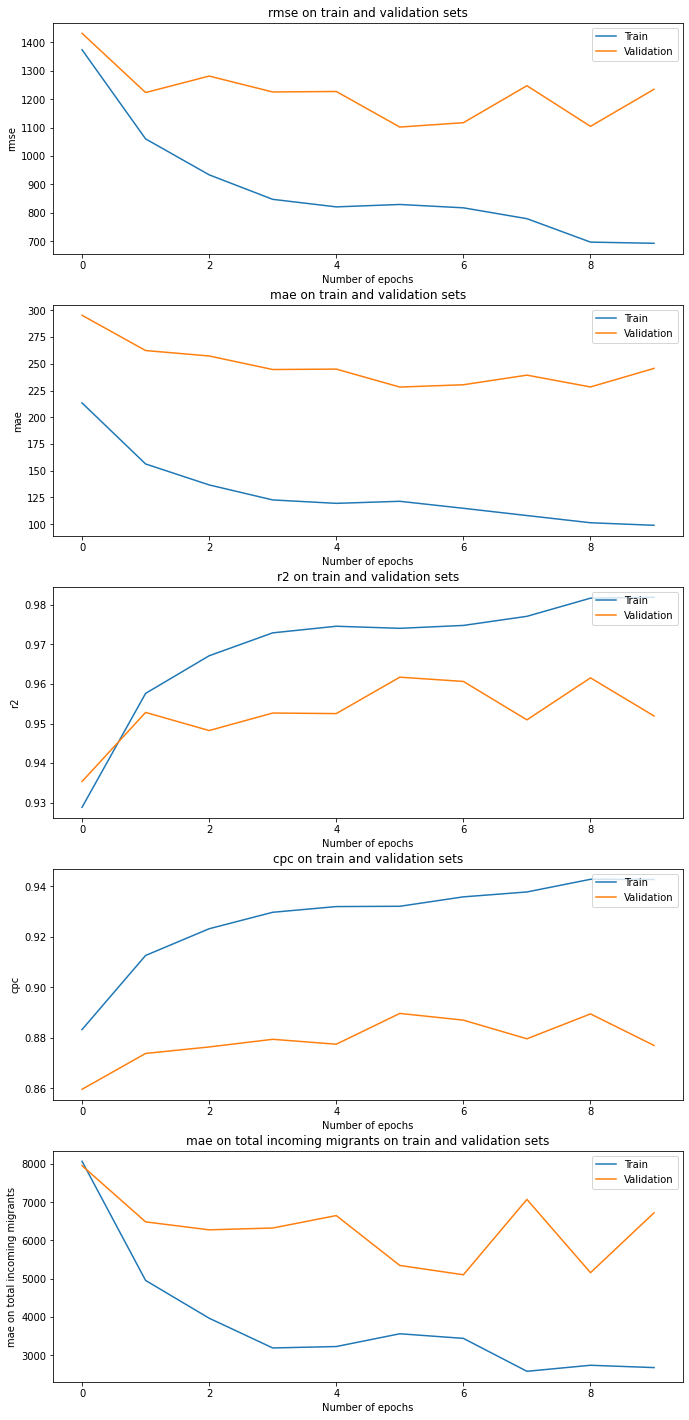

In [0]:
display_training(history)

Here is the values of the different metrics on the training and the test set for the LSTM model described above

Normalized data means that keep the normalized output to calculate the metrics (beware : the output values are normalized by serie origin-destination)

Total data means that we've unnormalized all the predictions in order to compare with the real values of migration flows

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in log10


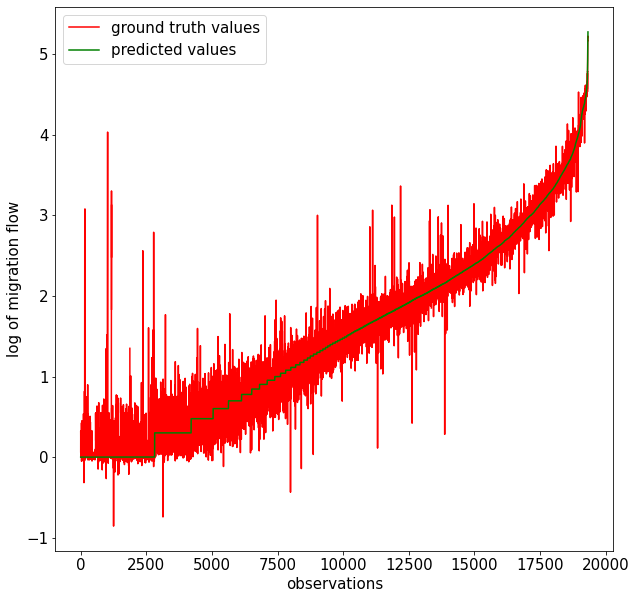

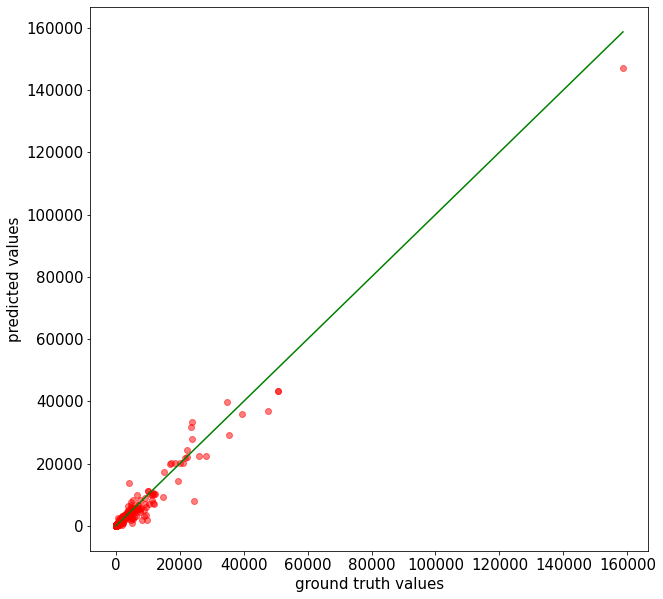

NORMALIZED TRAIN DATA :
rmse :
0.23555756452380028
mae :
0.16479797816485495
r2 :
0.5196100361495088
cpc :
0.7739612141964736

NORMALIZED TEST DATA :
rmse :
0.37328320813212024
mae :
0.29058953286693434
r2 :
0.05490998644110856
cpc :
0.6860855986068558

TOTAL TRAIN DATA :
rmse :
638.9931765583061
mae :
95.82729103633976
r2 :
0.9846039651159619
cpc :
0.9454065635182836

TOTAL TEST DATA :
rmse :
1027.9189277540465
mae :
224.57512644986863
r2 :
0.9666774946069759
cpc :
0.8916168440235068



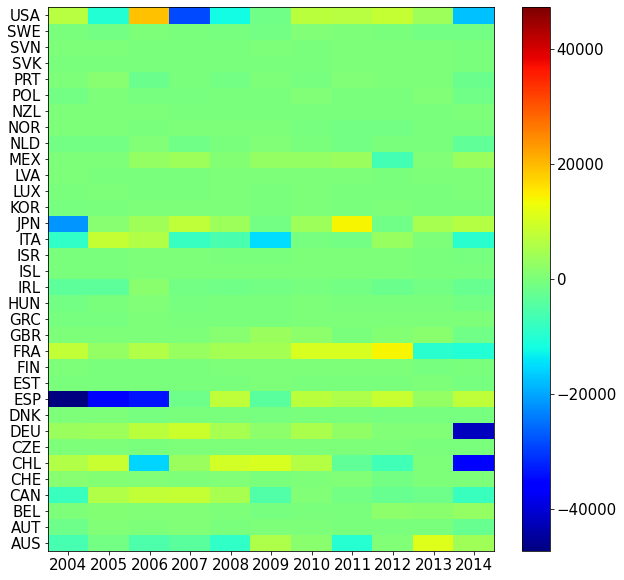

Mean absolute error over all years : 2261.0734987470264
Mean absolute error for 2014 : 4827.024742944714


In [0]:
dataResult = evaluateBySerie(model,dataLSTM)
dataResult.to_pickle('/data/bestResultLSTM.pkl')
#dataResult = pd.read_pickle('/data/bestResultLSTM.pkl')
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)
df = evaluation_year_dest(dataResult,'y_diff')

This last graph represent the error of the total incoming migrant per destination per year ( we sum the flows from all th origin countries)

## Gravity Model and Linear Regression

Based on [1, 4].


### Import dataset

In [0]:
# Transforms the stata file into a dataframe that can be manipulated more easily  
#
# @oldData                 : dataframe from [1] stata file (.dta extension)
# @returns              : a dframe, each row is a migration flow for a specified triple destination-origin-year, e.g AUS-AUT 2004 where the columns are :
#       - 'origin'          : code iso3 for the origin country 
#       - 'dest'            : code iso3 for the origin country
#       - 'year'            : the year of the migration flow
#       - 'language'        : the part of the population of the origin country speaking French/Spanish/English
#       - 'control_var'     : the (normalized) different control variables on the countries of origin and destination (population, GDP, ...)
#       - 'GTI'             : the (normalized) GTI values (uni and bi) for the different keywords
#       - 'fixed_effects'   : the one-hot vectors representing the country of origin, of destination and the year of the data
#       - 'y'               : the (normalized) output value to predict (dependent variable)
#       - 'tot_mig'         : the non-normalized migration flow between the 2 countries for each year
#       - 'internet'        : the part of the population of the origin country having acess to internet 
#       - 'X'       : the (normalized) input data for the pair origin-destination, for each year it contains :
#                   -the (normalized) control variables of the countries of origin and destination
#                   -the (normalized) GTI values of the country of origin
#                   -the fixed_effects (one-hot vectors) representing the year, the origin and the destination
# @use_log              : use the log value? Instead of the total value for the output and for the control variables
# @fixed_effects_origin : use origin fixed effects?
# @fixed_effects_dest   : use destination fixed effects?
# @fixed_effects_year   : use year fixed effects? (use maybe year since GT discontinuity from January 2011 ?)
# @normInTotal          : indicates if the data should be normalized over every time-series
# @min_speak    : remove origin countries where the language is spoken by less than @least min_speak 
# @min_internet : remove origin countries where internet penetration is less than @least min_internet
def getDataLinearReg(oldData,fixed_effects_origin=True,fixed_effects_dest=True,fixed_effects_year=True,use_log=True,normInTotal=False,min_speak = 0.0, min_internet = 0.0):
    data = oldData.copy()
    list_origins = list(dict.fromkeys(data['iso3_o']))
    list_dests = list(dict.fromkeys(data['iso3_d']))
    list_years = list(dict.fromkeys(data['year']))
    def addFixed_effects(row):
        Xfixed_effects = []
        if fixed_effects_origin:
            fx_o = [0.] * len(list_origins)
            fx_o[list_origins.index(row['iso3_o'])] = 1.
            Xfixed_effects += fx_o
        if fixed_effects_dest:
            fx_d = [0.] * len(list_dests)
            fx_d[list_dests.index(row['iso3_d'])] = 1.
            Xfixed_effects += fx_d
        if fixed_effects_year:
            fx_y = [0.] * len(list_years)
            fx_y[list_years.index(row['year'])] = 1.
            Xfixed_effects += fx_y
        return Xfixed_effects
    uniGTI_col = data.columns[13:80]
    biGTI_col = data.columns[81:148]
    control_var_col = data.columns[161:165]
    if use_log:
      control_var_col = data.columns[9:14]
    uniGTI = np.array(data[uniGTI_col]) * np.array(data['GTI_bil_0']).reshape((data.count()[0],1))
    biGTI = np.array(data[biGTI_col])
    control_var = np.array(data[control_var_col])
    language = data[['o_French','o_Spanish','o_English']].apply(max,axis=1)
    fixed_effects = list(data.apply(addFixed_effects, axis=1))
    GTI = np.hstack((biGTI,uniGTI))
    y = np.array(data['fwd_tot_mig'])
    if normInTotal:
      y = MinMaxScaler(feature_range=(0, 1)).fit_transform(y.reshape((len(y),1))).reshape((len(y)))
      control_var = MinMaxScaler(feature_range=(0, 1)).fit_transform(control_var)
      GTI = MinMaxScaler(feature_range=(0, 1)).fit_transform(GTI)
    if use_log:
      y = np.array(data['fwd_log_mig'])
    data['GTI'] = GTI.tolist()
    data['fixed_effects'] = fixed_effects
    data['control_var'] = control_var.tolist()
    data['y'] = y.tolist()
    data['language'] = language
    data['X'] = np.hstack((control_var, GTI, fixed_effects)).tolist()
    data.rename(columns={'iso3_o':'origin','iso3_d':'dest','o_IT_NET_USER_P2':'internet'},inplace=True)
    dataANN['X'][0] = [0.0] + dataANN['X'][0]
    # ATTENTION : the next two lines remove observations even when min_speak and min_internet = 0
    data = data.loc[data['language'] >= min_speak]   
    data = data.loc[data['internet'] >= min_internet]
    return data

In [0]:
dataLinearReg = getDataLinearReg(data)
dataLinearReg.to_pickle('/data/logDataLR.pkl')

### Train and evaluate model functions





In [0]:
# The model make predictions from the input values present in the dataframe set
# @LRModel : a sklearn model of Linear regression
# @set : a dataframe where each row is an observation containing the following columns :
#         - 'X' the input features for the linear regression
#         - 'y' the (normalized) output values of the observation 
#         - 'fwd_tot_mig' : the ground truth output value of the migration flow to predict
# @use_log : indicates if the output values are the log of the ground values
# @normInTotal : indicates if the output values were normed over the total dataset
# @scaler : the scaler used to norm the data (if there is any normalization)
# @returns :  - y : the (normalized) output values
#             - y_real : the ground truth output values
#             - y_pred : the (normalized) predicted output values
#             - y_real : the denormalized predicted output values 
def predict(LRModel,set,scaler,use_log=True,normInTotal=False):
    x = np.array(list(set['X']))
    y = np.array(list(set['y']))
    y_real = np.array(list(set['fwd_tot_mig']))
    y_pred = LRModel.predict(x)
    y_real_pred = y_pred
    if use_log:
        y_real_pred = np.exp(y_pred) - 1
    elif normInTotal:
        y_real_pred = scaler.inverse_transform(y_pred.reshape((len(y), 1))).reshape((len(y)))
    return y,y_real,y_pred,y_real_pred

# Train the linear regression model on the data passed in argument and evaluate it 
#
# @LRModel       : a sklearn model of Linear regression
# @data          : a dataframe like the getDataLinearReg returns
# @test_year     : the year used as test set
# @display       : indicates if the function must display the graphs of the evaluation
# @use_log       : indicates for the evaluation if the log values was used in @data
# @normInTotal   : indicates for the evaluation if @data was normed over all series origin-destination
# @returns   : 4 lists containing each the rmse, mae, r2 and cpc metrics for, respectively :
#       - train_metrics       : the normalized train set
#       - test_metrics        : the normalized test set
#       - total_train_metrics : the denormalized/total train set
#       - total_test_metrics  : the denormalized/total test set
#       - train/test    : 2 dataframes similar to the @data containing the observations of the train/test set with the additional columns :
#           'y_pred'      : the output value predicted by the model
#           'y_real_pred' : the denormalized/total output value predicted by the model
#           'y_diff'      : the difference between the denormalized/total output value predicted by the model and the true denormalized/total output value
def train_evaluateLR(LRModel,data,test_year=2014,display=True,use_log=True,normInTotal=False):
    train = data.loc[data['year'] != test_year]
    test = data.loc[data['year'] == test_year]
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(np.array(data['fwd_tot_mig']).reshape((len(data['fwd_tot_mig']),1)))
    x_train = np.array(list(train['X']))
    y_train = np.array(list(train['y']))
    LRModel = LRModel.fit(x_train, y_train)
    y_train,y_real_train,y_train_pred,y_real_train_pred = predict(LRModel,train,scaler,use_log=use_log,normInTotal=normInTotal)
    train['y_pred']= y_train_pred
    train['y_real_pred'] = y_real_train_pred
    train['y_diff'] = np.subtract(y_real_train_pred,y_real_train)
    y_test, y_real_test, y_test_pred, y_real_test_pred = predict(LRModel, test, scaler,use_log=use_log,normInTotal=normInTotal)
    test['y_pred'] = y_test_pred
    test['y_real_pred'] = y_real_test_pred
    test['y_diff'] = np.subtract(y_real_test_pred,y_real_test)
    if display:
        # plot of the difference between the predicted values and the ground truth values
        y_real = np.array(y_real_train.tolist() + y_real_test.tolist())
        y_pred = np.array(y_real_train_pred.tolist() + y_real_test_pred.tolist())
        y_diff_plot(y_real,y_pred,'y_diff_LR.svg')
        scatter_plot(y_real_test,y_real_test_pred,'scatter_LR.svg')
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    total_train_metrics = calculate_metrics(y_real_train, y_real_train_pred)
    total_test_metrics = calculate_metrics(y_real_test, y_real_test_pred)
    return train,test,train_metrics, test_metrics, total_train_metrics, total_test_metrics

In [0]:
# Calculate and display the sum of the @col values over all the origin countries for each destination country and each year
# 
# @oldData     : a Dataframe where each row is an obsrvation origin-destination-year (like the ones returned by the functions getDataLinerReg or train_evaluateLR)
# @col      : the name of the column of the @data dataFrame containing the values to sum
# @display  : indicates if it should display the heatmap of the values
# @name : name of the file in which to save the figure
# @test_year : the year corresponding to the test set
# @returns : the mean absolute values of @col for every destination country for the training and test set
def represent_year_dest_LR(oldData, col, display=True,name=None,test_year=2014):
    data = oldData.groupby(['pair_id']).agg({'dest': lambda x: x.tolist()[0],'year': lambda x: x.tolist(), col: lambda x: x.tolist()})
    years = list({y: None for row in list(data['year']) for y in row})
    dest = list(dict.fromkeys(data['dest']))
    groupedData = data.groupby(['dest']).agg({'year': lambda x: x.tolist(), col: lambda x: x.tolist()})

    def df(row):
        d = dict.fromkeys(years, 0.0)
        for i in range(len(row['year'])):
            for j in range(len(row['year'][i])):
                d[row['year'][i][j]] += float(row[col][i][j])
        return list(d.values())

    val = groupedData.apply(df, axis=1).to_list()
    df = pd.DataFrame(val, index=groupedData.index, columns=years)
    mae_train = np.mean(np.abs(np.array(df.loc[:,df.columns != test_year]))) # mean absolute value for the training set
    mae_test = np.mean(np.abs(np.array(df[test_year]))) # mean absolute value for the test set
    if display:
        heatmap(df,name)
        print('Mean absolute error for the training set : ' + str(mae_train))
        print('Mean absolute error for test set : ' + str(mae_test))
    return df

### Running the model : train + evaluation + visualization



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

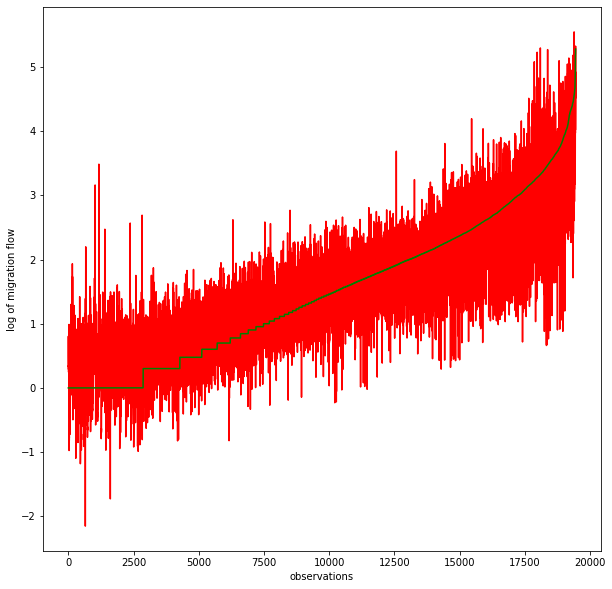

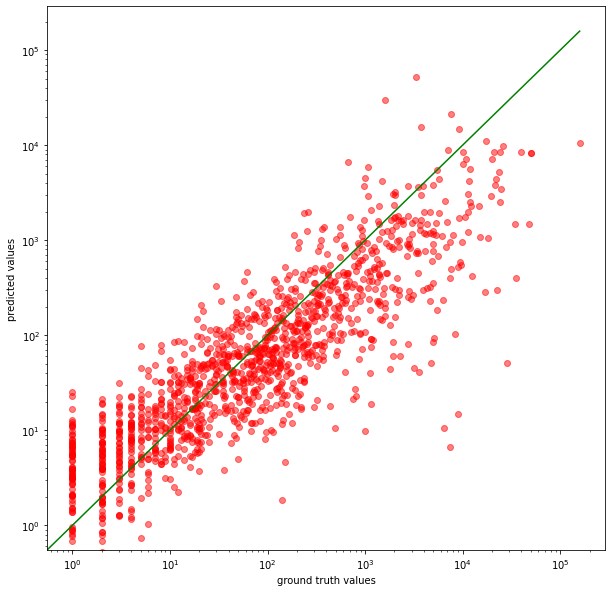

NORMALIZED TRAIN DATA :
rmse :
1.1749981890286398
mae :
0.8808439044240692
r2 :
0.7956726428782571
cpc :
0.8711300312518663

NORMALIZED TEST DATA :
rmse :
1.2662758142499226
mae :
0.9559947347931924
r2 :
0.7725596468565958
cpc :
0.8655411213091242

TOTAL TRAIN DATA :
rmse :
6099.701855622258
mae :
819.4371175292725
r2 :
-0.4075944577052968
cpc :
0.47161299933698503

TOTAL TEST DATA :
rmse :
5239.371541383575
mae :
877.4191014905953
r2 :
0.10097462937417845
cpc :
0.3791830191247549



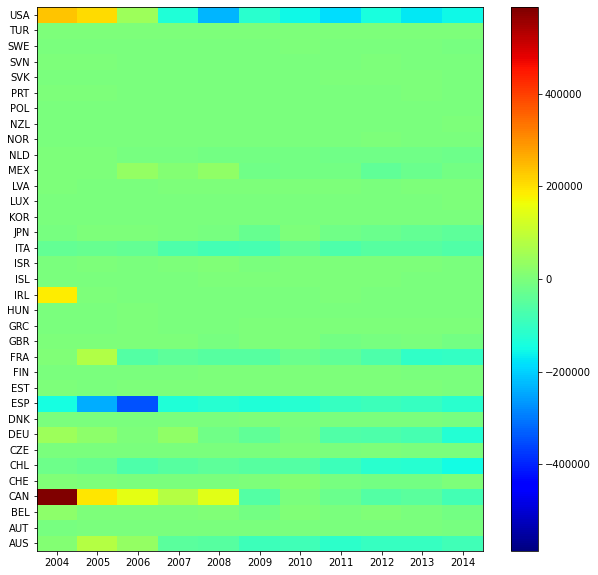

Mean absolute error for the training set : 23667.172256900474
Mean absolute error for test set : 28737.19953188911


In [0]:
dataLinearReg = pd.read_pickle('/data/logDataLR.pkl')
LRModel = LinearRegression()
trainLR,testLR,train_metrics,test_metrics,total_train_metrics,total_test_metrics = train_evaluateLR(LRModel,dataLinearReg)

print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

df = represent_year_dest_LR(trainLR.append(testLR),'y_diff',name='dest_LR.svg')

## ANN Model

Based on [5].

### Import dataset


In [0]:
#we use the same function to import the data as the linear regression
dataANN = getDataLinearReg(data,use_log=False,normInTotal=True)
dataANN.to_pickle('/data/dataANN.pkl')

In [0]:
#Separate th dataframe @data in 6 np.arrays : the input and output arrays of the training, validation and test set
def separate_data(data,valid_year=2013,test_year=2014):
  train = data.loc[data['year']<valid_year]
  valid = data.loc[data['year']==valid_year]
  test = data.loc[data['year']==test_year]
  return np.array(list(train['X'])),np.array(list(train['y'])),np.array(list(valid['X'])),np.array(list(valid['y'])),np.array(list(test['X'])),np.array(list(test['y']))

In [0]:
dataANN = pd.read_pickle('/data/dataANN.pkl')
X_train,y_train,X_valid,y_valid,X_test,y_test = separate_data(dataANN)

### Model definition

In [0]:
# define ANN model
# @l : loss function to build model
# @size_hidden_layer : the size of all the hidden layers of the ANN 
# @dropout : the dropout of the model
# @n_layer : the number of hidden layers of the model
# @returns : the defined model
def defineANN(data,l=cpc_loss,size_hidden_layer=50,dropout=0.0,n_layer=1):
  n_features = len(data['X'][0]) 
  model = Sequential()
  if dropout > 0.0:
    model.add(Dropout(dropout,input_shape=(n_features,)))
  for i in range(n_layer):
    model.add(Dense(size_hidden_layer, activation='relu', input_shape=(n_features,)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss=l, metrics = custom_metrics)
  return model

### Optimization of the ANN's hyperparameters

We train the models on the span of years from 2004 to 2012 and validate it on the year 2013.

Following the precedent validation we train our  best model on the training (2004-2012 and validation set (2013) and evaluate it on the test set (2014).
We optimize the following hyperparameters and present them along with their optimal value : 
* loss function - MAE using adam optimizer, 
* number and size of hidden layers - 2 hidden layers of size 200
* batch size : 32
* number of epochs - 170, 
* and dropout - 0.10.




### Evaluation of the optimized ANN model ###

The evaluation is done on the test year (2014).




In [0]:
modelANN_MAE2 = defineANN(dataANN,l='mae',size_hidden_layer=200,n_layer=2,dropout=0.1)
histMAE = modelANN_MAE2.fit(np.vstack((X_train,X_valid)),np.array(y_train.tolist()+y_valid.tolist()),batch_size=32,epochs=170,validation_data=(X_test,y_test))

Epoch 1/170
560/560 [==============================] - 1s 2ms/step - loss: 0.0136 - cpc: -0.2591 - mse: 0.0010 - r_squared: -28.1071 - mae: 0.0136 - val_loss: 0.0078 - val_cpc: -1.8280 - val_mse: 7.4781e-04 - val_r_squared: -25.8381 - val_mae: 0.0079
Epoch 2/170
560/560 [==============================] - 1s 2ms/step - loss: 0.0052 - cpc: 0.3600 - mse: 5.4648e-04 - r_squared: -1.2910 - mae: 0.0052 - val_loss: 0.0051 - val_cpc: 0.2394 - val_mse: 6.3160e-04 - val_r_squared: -7.0862 - val_mae: 0.0051
Epoch 3/170
560/560 [==============================] - 1s 2ms/step - loss: 0.0038 - cpc: 0.4192 - mse: 4.5772e-04 - r_squared: 0.1517 - mae: 0.0038 - val_loss: 0.0048 - val_cpc: 0.3363 - val_mse: 6.3470e-04 - val_r_squared: -1.1256 - val_mae: 0.0049
Epoch 4/170
560/560 [==============================] - 1s 2ms/step - loss: 0.0032 - cpc: 0.5161 - mse: 3.7367e-04 - r_squared: 0.2336 - mae: 0.0032 - val_loss: 0.0041 - val_cpc: -0.5135 - val_mse: 3.9327e-04 - val_r_squared: -0.3818 - val_mae: 0.00

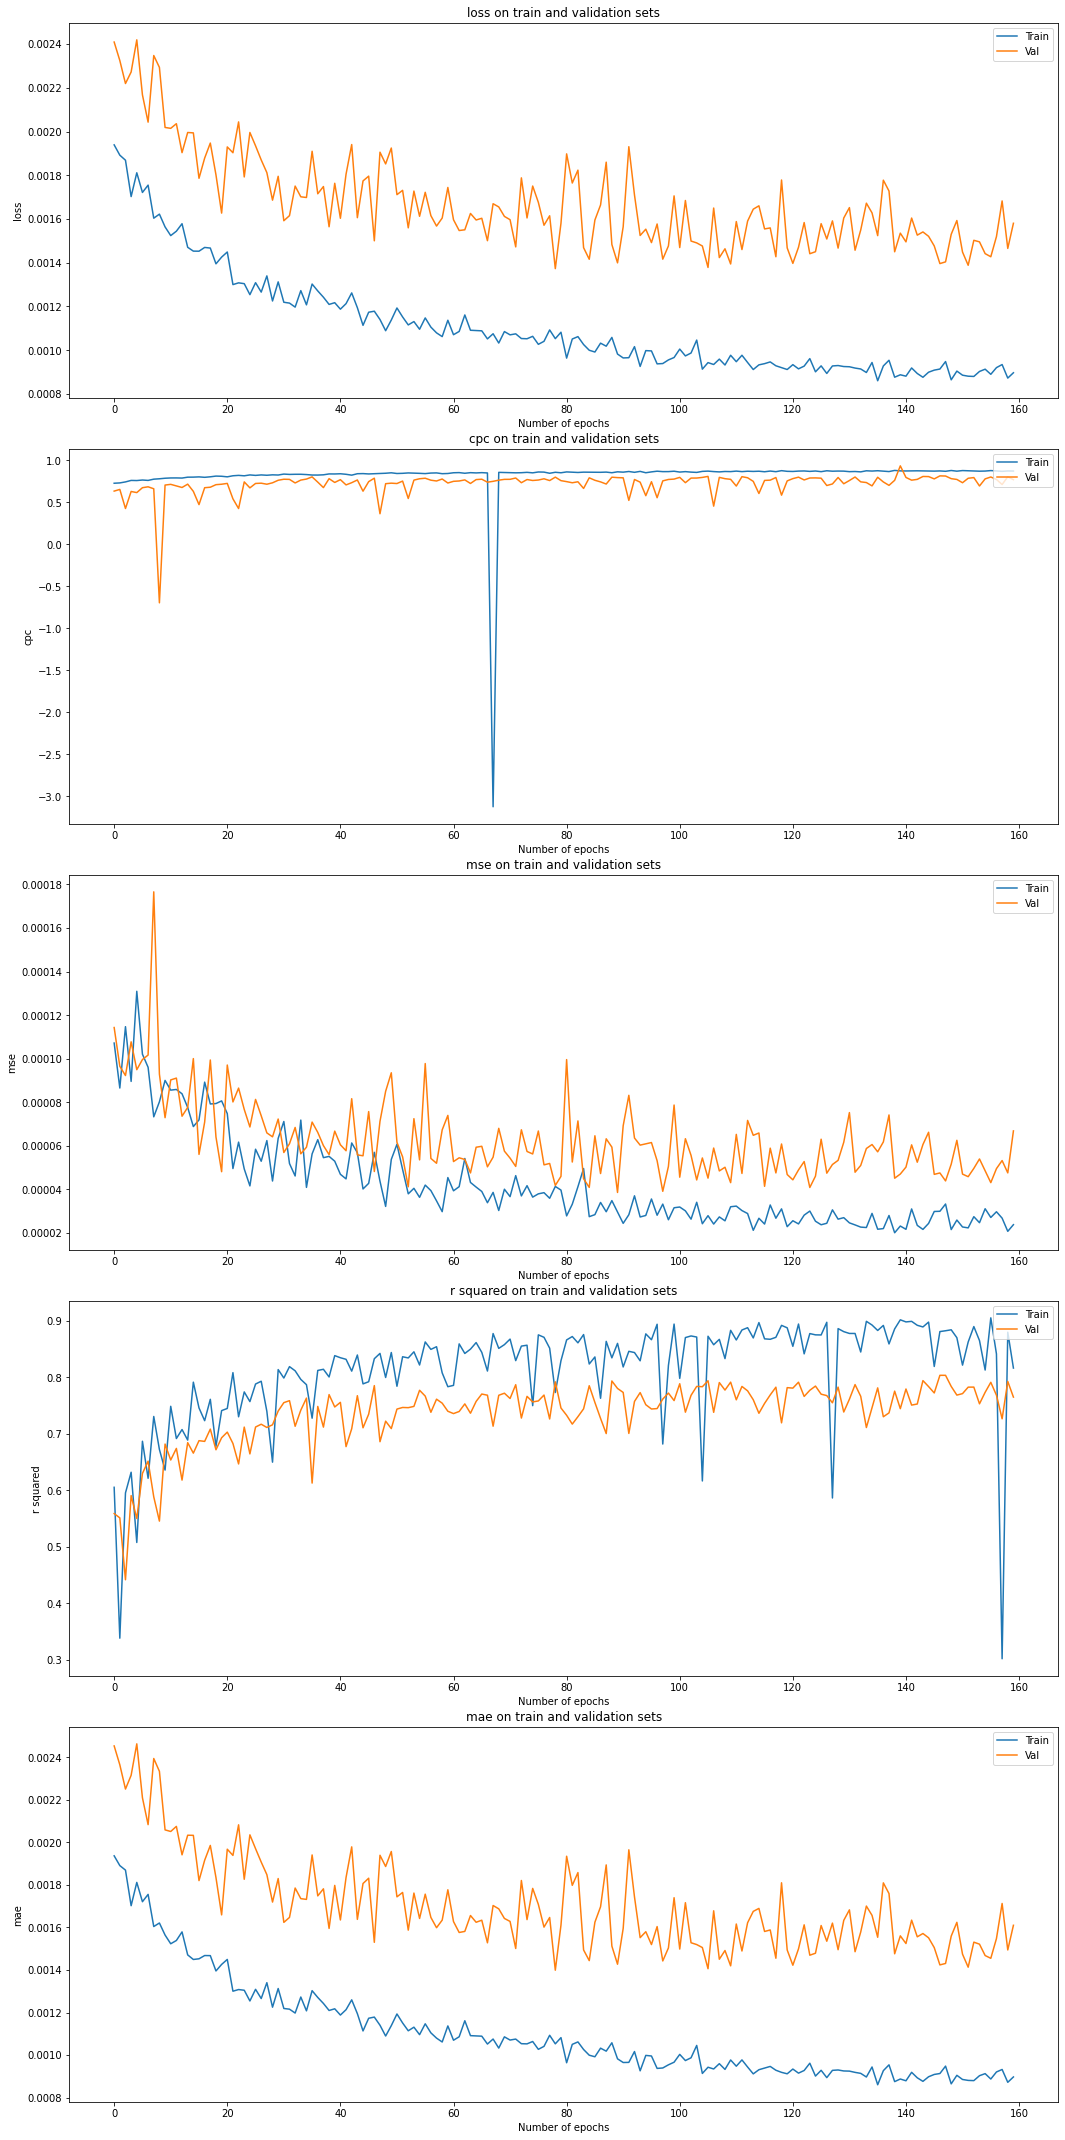

In [0]:
model_metrics = histMAE.history
half = int(len(model_metrics) / 2)
train_metrics, val_metrics = list(model_metrics.keys())[:half], list(model_metrics.keys())[half:]
ratio = 15
fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
fig.tight_layout(pad=3.0)
for i in range(half):
    ax[i].set_title(train_metrics[i].replace("_", " ") + ' on train and validation sets')
    ax[i].plot(model_metrics[train_metrics[i]][10:])
    ax[i].plot(model_metrics[val_metrics[i]][10:])
    ax[i].set_ylabel(train_metrics[i].replace("_", " "))
    ax[i].set_xlabel('Number of epochs')
    ax[i].legend(['Train', 'Val'], loc='upper right')

In [0]:
# Evaluate the ANN model on the data passed in argument 
#
# @LRModel       : a keras ANN model
# @data          : a dataframe like the getDataLinearReg returns
# @test_year     : the year used as test set
# @display       : indicates if the function must display the graphs of the evaluation
# @use_log       : indicates for the evaluation if the log values was used in @data
# @normInTotal   : indicates for the evaluation if @data was normed over all series origin-destination
# @returns   : 4 lists containing each the rmse, mae, r2 and cpc metrics for, respectively :
#       - train_metrics       : the normalized train set
#       - test_metrics        : the normalized test set
#       - total_train_metrics : the denormalized/total train set
#       - total_test_metrics  : the denormalized/total test set
#       - train/test    : 2 dataframes similar to the @data containing the observations of the train/test set with the additional columns :
#           'y_pred'      : the output value predicted by the model
#           'y_real_pred' : the denormalized/total output value predicted by the model
#           'y_diff'      : the difference between the denormalized/total output value predicted by the model and the true denormalized/total output value
def evaluateANN(LRModel,data,test_year=2014,display=True,use_log=False,normInTotal=True):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(np.array(data['fwd_tot_mig']).reshape((len(data['fwd_tot_mig']),1)))
    train = data.loc[data['year'] != test_year]
    test = data.loc[data['year'] == test_year]
    y_train,y_real_train,y_train_pred,y_real_train_pred = predict(LRModel,train,scaler,use_log=use_log,normInTotal=normInTotal)
    train['y_pred']= y_train_pred
    train['y_real_pred'] = y_real_train_pred
    train['y_diff'] = np.subtract(y_real_train_pred,y_real_train)
    y_test, y_real_test, y_test_pred, y_real_test_pred = predict(LRModel, test, scaler,use_log=use_log,normInTotal=normInTotal)
    test['y_pred'] = y_test_pred
    test['y_real_pred'] = y_real_test_pred
    test['y_diff'] = np.subtract(y_real_test_pred,y_real_test)
    if display:
        y_real = np.array(y_real_train.tolist() + y_real_test.tolist())
        y_pred = np.array(y_real_train_pred.tolist() + y_real_test_pred.tolist())
        y_diff_plot(y_real,y_pred,'y_diff_ANN.svg')
        scatter_plot(y_real_test,y_real_test_pred,'scatter_ANN.svg')
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    total_train_metrics = calculate_metrics(y_real_train, y_real_train_pred)
    total_test_metrics = calculate_metrics(y_real_test, y_real_test_pred)
    return train,test,train_metrics, test_metrics, total_train_metrics, total_test_metrics

In [0]:
train,test,train_metrics,test_metrics,total_train_metrics,total_test_metrics = evaluateANN(modelANN_MAE2,dataANN)
train.to_pickle('/data/resultANN_train.pkl')
test.to_pickle('/data/resultANN_test.pkl')
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

df = represent_year_dest_LR(train.append(test),'y_diff',name='dest_ANN.svg')

## Visualization of all the models

We separate the dataframe contained in bestResultLSTM.pkl in 8 np.arrays, 4 arrays for each the predictions (*_pred*) and the ground truth values (*_real*) :

* train set array
* test set array
* normalized data
* denormalized data


In [0]:
def separate(row):
    if 2014 in row['year']:
        return [row['y'][:-1],[row['y'][-1]],row['y_pred'][:-1],[row['y_pred'][-1]],row['tot_mig'][:-1],[row['tot_mig'][-1]],row['y_real_pred'][:-1],[row['y_real_pred'][-1]]]
    else:
        return [row['y'],[],row['y_pred'],[],row['tot_mig'],[],row['y_real_pred'],[]]
def flatten(l):
    return [[x for serie in set for x in serie] for set in l]
dataResult  = pd.read_pickle('/data/bestResultLSTM.pkl')
allDataLSTM = dataResult.apply(separate,axis=1)
allDataLSTM = list(map(list,zip(*allDataLSTM)))
[y_train,y_test,y_train_pred,y_test_pred,y_real_train,y_real_testLSTM,y_real_train_pred,y_real_test_predLSTM] = flatten(allDataLSTM)

### Scatter plot of the test set (year 2014) for the 3 models



In [0]:
test= pd.read_pickle('/data/resultANN_test.pkl')
y_pred_testLR = testLR['y_real_pred']
y_real_testLR = testLR['fwd_tot_mig']
y_pred_testANN = test['y_real_pred']
y_real_testANN = test['fwd_tot_mig']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  


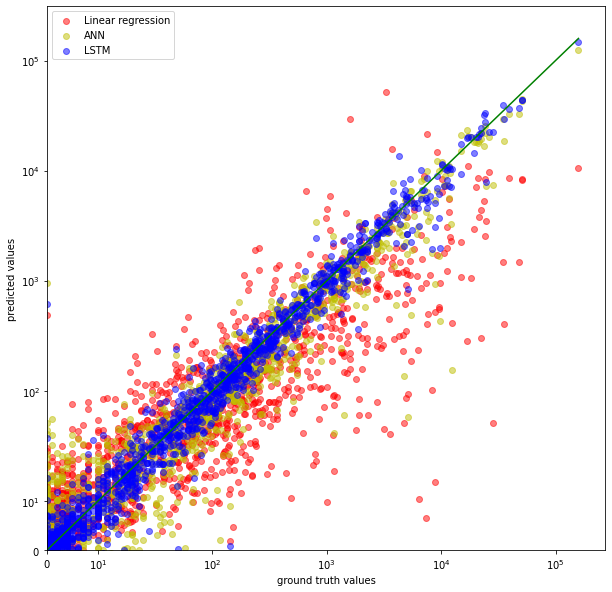

In [0]:
fig2 = plt.figure(figsize=(10,10))
log_norm = SymLogNorm(vmin=0,vmax=np.max(y_real_testLR),linthresh=10.0,linscale=1.0)
ax = plt.scatter(y_real_testLR,y_pred_testLR,c='r',alpha=0.5,label='Linear regression',norm=log_norm)
ax = plt.scatter(y_real_testANN,y_pred_testANN,c='y',alpha=0.5,label='ANN',norm=log_norm)
ax = plt.scatter(y_real_testLSTM,y_real_test_predLSTM,c='b',alpha=0.5,label='LSTM',norm=log_norm)
plt.plot(range(0, int(np.max(y_real_testLR))),range(0, int(np.max(y_real_testLR) )),'g')
plt.xlabel('ground truth values')
plt.ylabel('predicted values')
plt.yscale('symlog',linthreshy=10,linscaley=0.4)
plt.xscale('symlog',linthreshx=10,linscalex=0.4)
plt.ylim(bottom=0.)
plt.xlim(left=0.)
plt.legend()
plt.show()
fig2.savefig('scatter_all.svg', bbox_inches = 'tight',pad_inches = 0)

### Heatmaps of the error on total incoming migrants per destination per year for the 3 models and heatmap of the ground truth values for the total number of incoming migrants per destination per year

Create DataFrame of the ground truth values of the total incoming migrants per destination (rows) per year (column)

In [0]:
data = trainLR.append(testLR).groupby(['pair_id']).agg({'dest': lambda x: x.tolist()[0],'year': lambda x: x.tolist(), 'fwd_tot_mig': lambda x: x.tolist()})
years = list({y: None for row in list(data['year']) for y in row})
dest = list(dict.fromkeys(data['dest']))
groupedData = data.groupby(['dest']).agg({'year': lambda x: x.tolist(), 'fwd_tot_mig': lambda x: x.tolist()})

def df(row):
    d = dict.fromkeys(years, 0.0)
    for i in range(len(row['year'])):
        for j in range(len(row['year'][i])):
            d[row['year'][i][j]] += float(row['fwd_tot_mig'][i][j])
    return list(d.values())

val = groupedData.apply(df, axis=1).to_list()
df_tot = pd.DataFrame(val, index=groupedData.index, columns=years)
df_tot = df_tot.drop(['TUR'])
tot_mig_by_dest = dict.fromkeys(list(df_tot.index))
for country, row in df_tot.iterrows():
    tot_mig_by_dest[country] = np.sum(row)
sorted_dest = [k for k, _ in sorted(tot_mig_by_dest.items(), key=lambda item: item[1],reverse=True)]
df_tot = df_tot.loc[sorted_dest,:]
df_tot.columns = range(2005,2016)

Create the DataFrame of the error on total incoming migrants per destination (row) per year (column) for each of the 3 models

In [0]:
trainANN = pd.read_pickle('/content/drive/My Drive/master thesis/Colab Notebook/resultANN_train.pkl')
testANN= pd.read_pickle('/content/drive/My Drive/master thesis/Colab Notebook/resultANN_test.pkl')
dataResult  = pd.read_pickle('/content/drive/My Drive/master thesis/Colab Notebook/bestResultLSTM.pkl')
df_LR = represent_year_dest_LR(trainLR.append(testLR),'y_diff',display=None)
df_ANN  = represent_year_dest_LR(trainANN.append(testANN),'y_diff',display=None)
df_LR = df_LR.loc[sorted_dest,:]
df_ANN= df_ANN.loc[sorted_dest,:]
df_LR.columns = range(2005,2016)
df_ANN.columns = range(2005,2016)


#get dataframe for LSTM
years = list({y:None for row in list(dataResult['year']) for y in row})
dest = list(dict.fromkeys(dataResult['dest']))
groupedData = dataResult.groupby(['dest']).agg({'year': lambda x:x.tolist(), 'y_diff': lambda x:x.tolist()})
# this function calculate the sum of the @col values over all the origin countries for every pair destination country-year
def df(row):
    d = dict.fromkeys(years,0.0)
    for i in range(len(row['year'])):
        for j in range(len(row['year'][i])): 
            d[row['year'][i][j]] += float(row['y_diff'][i][j])
    return list(d.values())
val = groupedData.apply(df,axis=1).to_list()
df_LSTM = pd.DataFrame(val,index = groupedData.index, columns = years)
df_LSTM = df_LSTM.loc[sorted_dest,:]
df_LSTM.columns = range(2005,2016)

Display the Heatmaps

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  


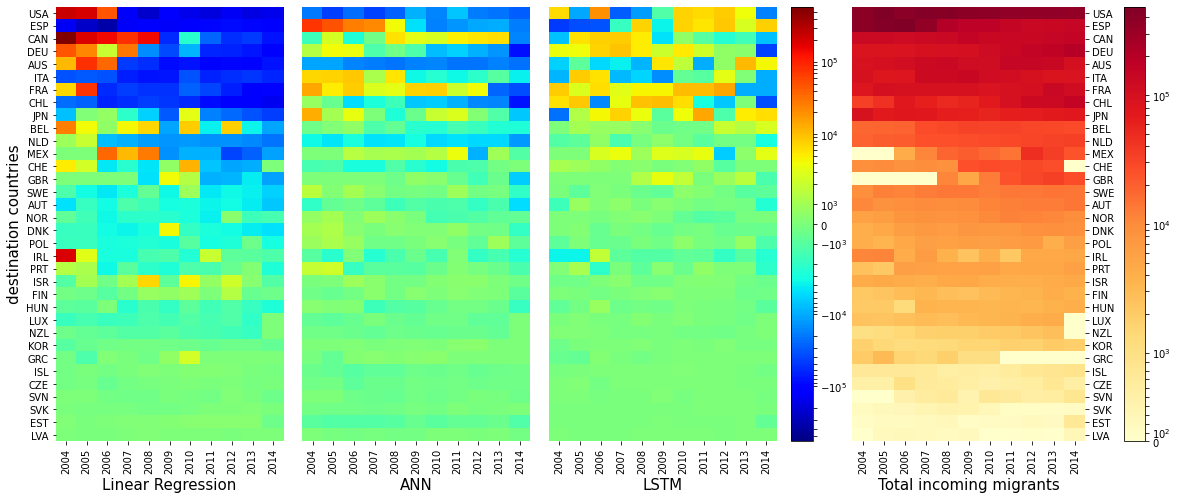

In [0]:
vmax = df_LR.max().max()
vmin = df_LR.min().min()
vlimit = max(vmax,-vmin)
log_norm = SymLogNorm(vmin=1,vmax=vlimit,linthresh=2000.0,linscale=0.8)
vmax_tot = df_tot.max().max()
log_norm_tot = SymLogNorm(vmin=1,vmax=vmax_tot,linthresh=1000.0,linscale=1.0)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(20,8),gridspec_kw={'width_ratios': [1.0, 1.0,1.25,1.4]})
fig.subplots_adjust(wspace=0.07)
sns.heatmap(df_LR, cmap='jet',ax=ax1,norm=log_norm,vmin=-vlimit,vmax=vlimit,cbar=False) # 'rainbow'
sns.heatmap(df_ANN, cmap='jet',ax=ax2,norm=log_norm,vmin=-vlimit,vmax=vlimit,cbar=False)
sns.heatmap(df_LSTM, cmap='jet',ax=ax3,norm=log_norm,vmin=-vlimit,vmax=vlimit,cbar=False)
sns.heatmap(df_tot, cmap='YlOrRd',ax=ax4,norm=log_norm_tot,cbar=False)
fig.colorbar(ax3.collections[0],ax=ax3, location='right', use_gridspec=False,pad=0.05)
fig.colorbar(ax4.collections[0],ax=ax4, location='right', use_gridspec=False,pad=0.12)

ax3.tick_params(rotation=90)
ax4.tick_params(rotation=0)
for tick in ax4.get_yticklabels():
    tick.set_rotation(90)
for tick in ax4.get_xticklabels():
    tick.set_rotation(90)
ax4.yaxis.tick_right()
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_ylabel('destination countries',fontsize=15.0)
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax1.set_xlabel('Linear Regression',fontsize=15.0)
ax2.set_xlabel('ANN',fontsize=15.0)
ax3.set_xlabel('LSTM',fontsize=15.0)
ax4.set_xlabel('Total incoming migrants',fontsize=15.0)
plt.show()
fig.savefig('dest_all_tot.svg', bbox_inches = 'tight',pad_inches = 0)

## References ##


[1] M. H. Böhme, A. Gröger, and T. Stöhr, “Searching for a better life: Predicting international migration with online search keywords,” Journal of Development Economics, vol. 142, p. 102347, Jan. 2020, doi: 10.1016/j.jdeveco.2019.04.002.

[2] F. A. Gers, J. Schmidhuber, and F. Cummins, “Learning to Forget: Continual Prediction with LSTM,” Neural Computation, vol. 12, no. 10, pp. 2451–2471, Oct. 2000, doi: 10.1162/089976600300015015.

[3] S. Hochreiter and J. Schmidhuber, “Long short-term memory,” Neural computation, vol. 9, no. 8, pp. 1735–1780, 1997.

[4] A. P. Masucci, J. Serras, A. Johansson, and M. Batty, “Gravity versus radiation models: On the importance of scale and heterogeneity in commuting flows,” Physical Review E, vol. 88, no. 2, p. 022812, 2013.

[5] C. Robinson and B. Dilkina, “A machine learning approach to modeling human migration,” in Proceedings of the 1st ACM SIGCAS Conference on Computing and Sustainable Societies, 2018, pp. 1–8.







